# 📝 **Tarea semana 4 - Opción Low-Code: Imputación de valores faltantes y modelado de series temporales**

**Integrantes:**

*   Adrián Bedón
*   Jairo Bedón
*   Andrea Cobos
*   Xavier Ramos

## 📌 **Descripción del dataset**

El conjunto de datos corresponde a mediciones de calidad del aire recogidas en una estación en Italia, con registros horarios entre marzo de 2004 y abril de 2005.
Las variables principales son:

| N° | Variable      | Descripción                                                               |
| -- | ------------- | ------------------------------------------------------------------------- |
| 2  | CO(GT)        | Concentración verdadera de CO (mg/m³, referencia)                         |
| 3  | PT08.S1(CO)   | Respuesta del sensor de óxido de estaño (target: CO)                      |
| 4  | NMHC(GT)      | Concentración verdadera de hidrocarburos no metánicos (μg/m³, referencia) |
| 5  | C6H6(GT)      | Concentración verdadera de benceno (μg/m³, referencia)                    |
| 6  | PT08.S2(NMHC) | Respuesta del sensor de titania (target: NMHC)                            |
| 7  | NOx(GT)       | Concentración verdadera de NOx (ppb, referencia)                          |
| 8  | PT08.S3(NOx)  | Respuesta del sensor de óxido de tungsteno (target: NOx)                  |
| 9  | NO2(GT)       | Concentración verdadera de NO2 (μg/m³, referencia)                        |
| 10 | PT08.S4(NO2)  | Respuesta del sensor de óxido de tungsteno (target: NO2)                  |
| 11 | PT08.S5(O3)   | Respuesta del sensor de óxido de indio (target: O3)                       |
| 12 | T             | Temperatura (°C)                                                          |
| 13 | RH            | Humedad relativa (%)                                                      |
| 14 | AH            | Humedad absoluta                                                          |


## 🎯 **Propósito de la tarea**

La tarea tiene dos objetivos principales:

### 1️⃣ **Imputación de valores faltantes**


* Simular valores faltantes en el dataset mediante dos enfoques:

  * **Aleatorio (at random)**: Se eliminan valores de forma dispersa.
  * **En bloques (in blocks)**: Se eliminan valores en secuencias consecutivas para simular fallos de sensores.
* Aplicar un método de imputación (por ejemplo, interpolación, modelo simple, técnica automática de la biblioteca proporcionada) para completar los datos.

### 2️⃣ **Modelado de serie temporal**


* Seleccionar una variable adecuada para modelar con un **LSTM** o un **Transformer**.
* La variable recomendada es:
  **CO(GT)** (Concentración de monóxido de carbono en mg/m³)
  👉 **Justificación:** CO(GT) es una variable con patrones estacionales y tendencias temporales claras, es de interés ambiental y presenta correlación con otras mediciones del dataset.
* Desarrollar un modelo básico (low-code) para predecir el valor futuro de CO(GT), usando las variables disponibles como entradas y evaluando el desempeño del modelo.


## ⚙️ **Instrucciones**

* Esta es una tarea **low-code**: Se proporcionarán plantillas de código o scripts básicos, enfócate en:

  * Comprender el proceso de imputación y modelado.
  * Ejecutar el flujo de trabajo.
  * Interpretar y discutir los resultados: calidad de la imputación y precisión del modelo de predicción.
* Analizar las métricas (MAE, MSE, RMSE, R²) para la imputación y la predicción.


## ✅ **Entregables**

* Un breve informe que incluya:

  * Gráficos de la serie original, con y sin imputación.
  * Métricas de evaluación de la imputación.
  * Gráficos y métricas del modelo LSTM o Transformer (por ejemplo: RMSE en test).
  * Reflexión sobre la calidad de la imputación y el modelo.

## 🎯 Generación de valores faltantes aleatorios (Missing At Blocks)

En esta parte se introduce un 20% de valores faltantes en el dataset diario en forma de bloques en cada columna. Esto simula errores aislados en la medición, típicos de fallos esporádicos en los sensores.

Number of missing values introduced in Block: 838
Number of missing values introduced at Random: 936


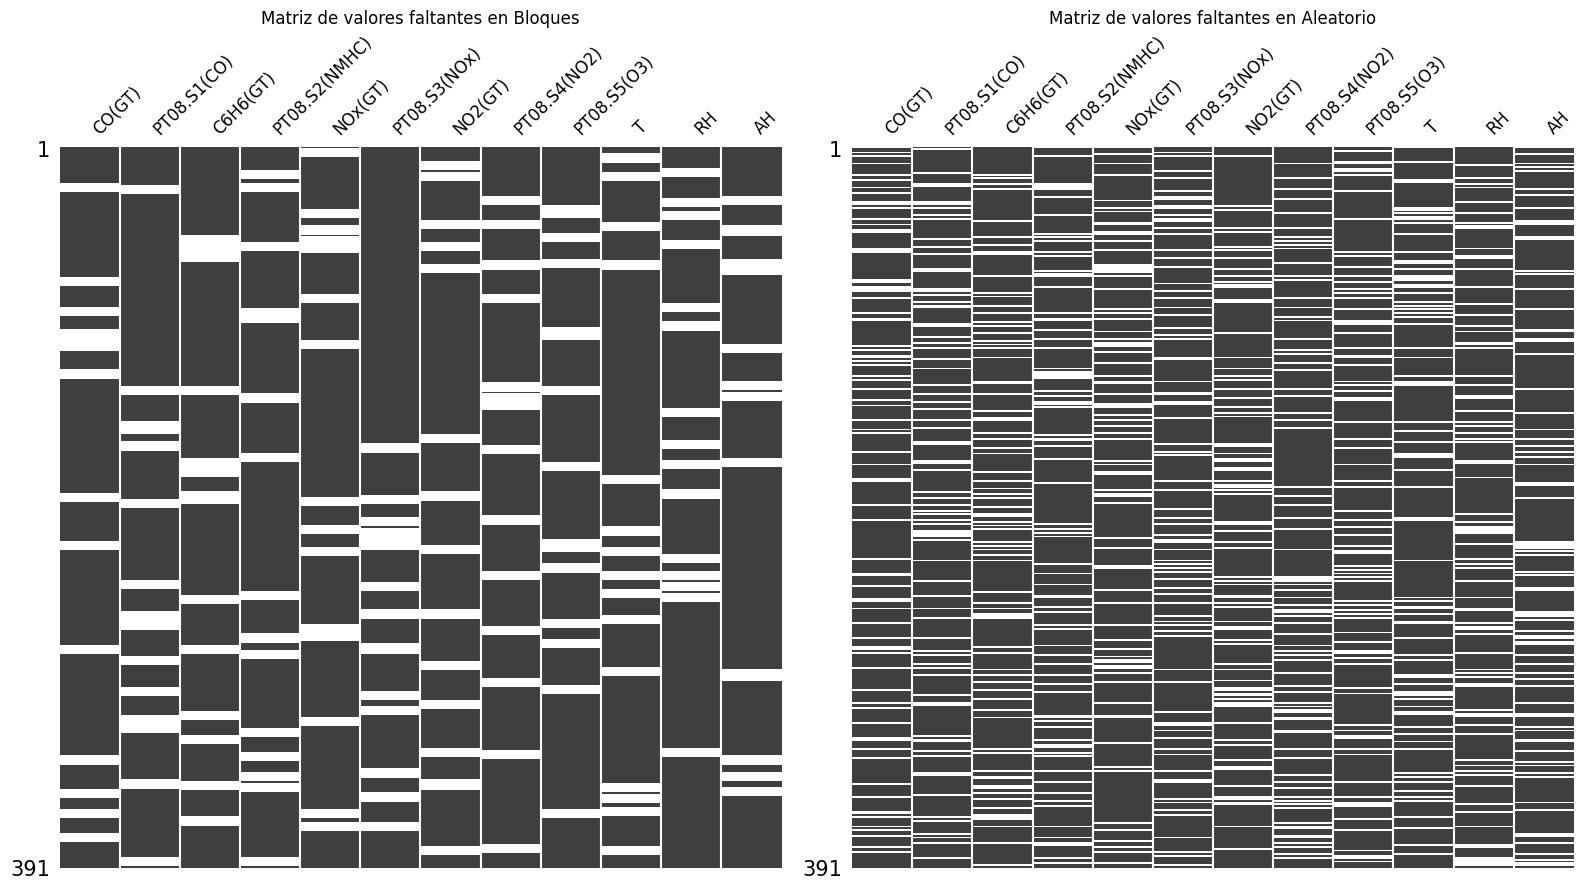

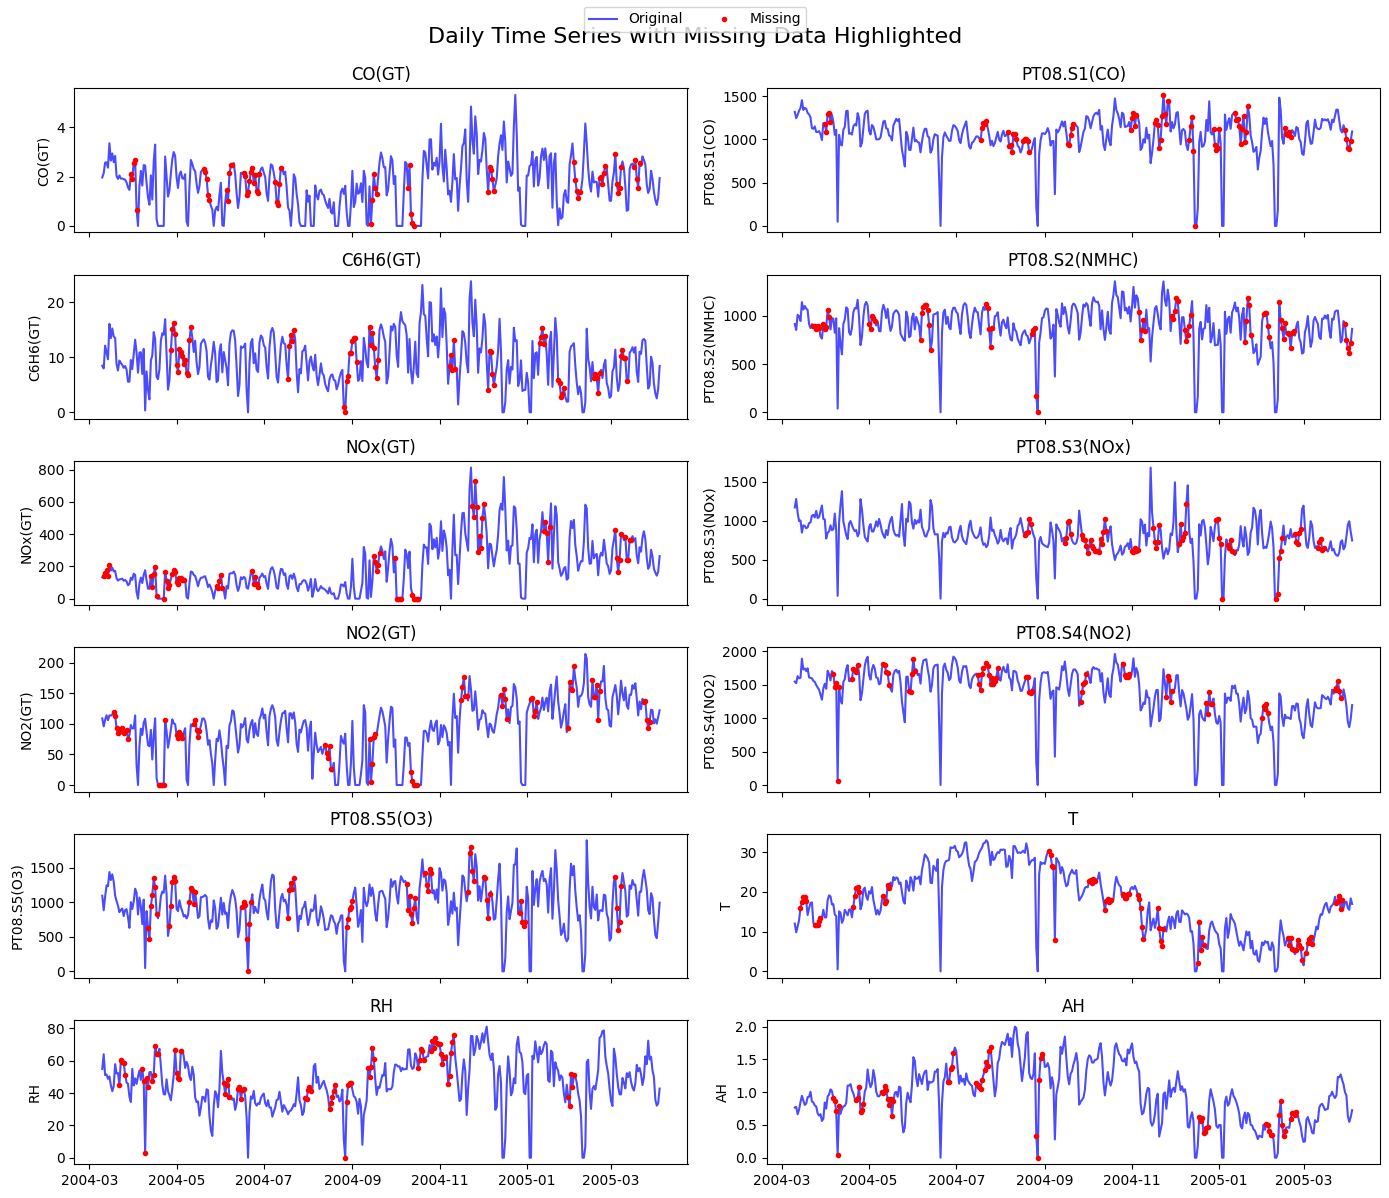

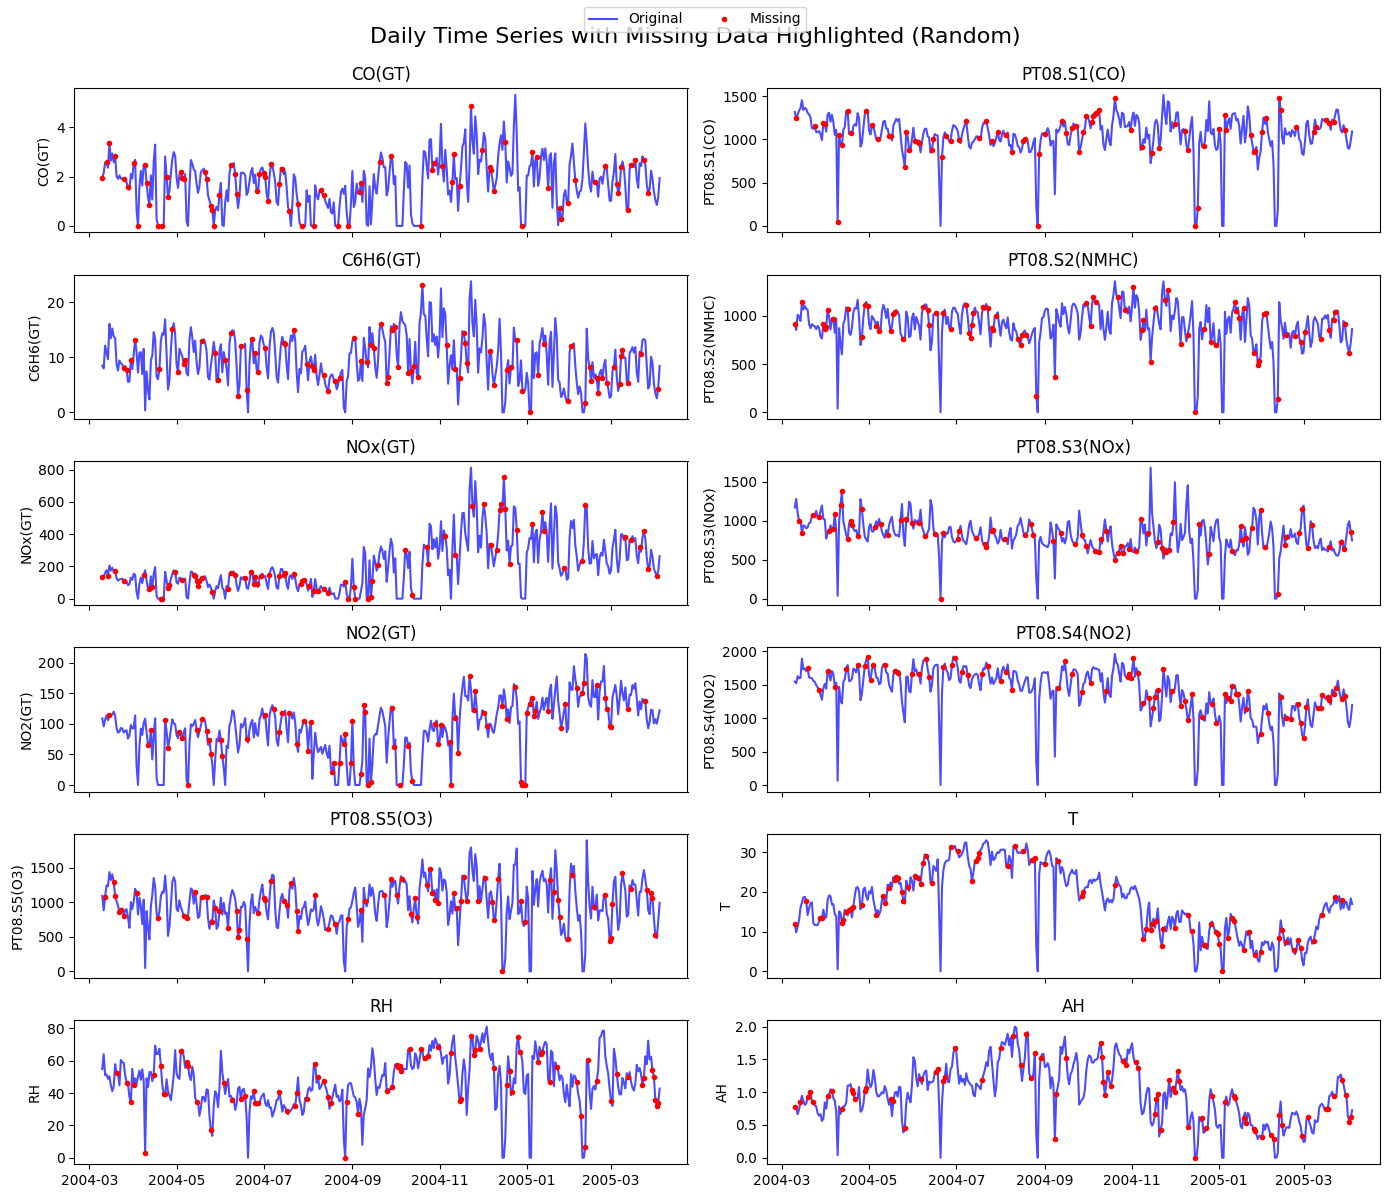

In [1]:
# ----------------------------------------
# 📌 IMPORTAR LIBRERÍAS
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# ----------------------------------------
# 📌 CARGAR EL DATASET
# ----------------------------------------
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/rna-online/refs/heads/main/data/AirQualityUCI.csv')

# Combina fecha y hora en un solo índice de tipo datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('DateTime')

# Convierte los datos a numérico y reemplaza valores negativos por 0
df = df.apply(pd.to_numeric, errors='coerce')
df[df < 0] = 0

# Elimina la columna NMHC(GT) por calidad de datos
if 'NMHC(GT)' in df.columns:
    df = df.drop(columns=['NMHC(GT)'])

# Resamplea a datos diarios calculando la media
df_daily = df.resample('D').mean()
df_original = df_daily.copy()

# ----------------------------------------
# 📌 INTRODUCIR VALORES FALTANTES ALEATORIAMENTE POR COLUMNA
# ----------------------------------------
def introduce_missing_per_column(data, frac=0.2):
    """
    Introduce valores faltantes de forma aleatoria por columna.

    Parámetros:
    - data: DataFrame de entrada
    - frac: Fracción de datos a eliminar por columna

    Retorna:
    - data_missing: DataFrame con valores faltantes introducidos
    - nan_mask: Máscara booleana que marca los NaN introducidos
    """
    data_missing = data.copy()
    nan_mask = pd.DataFrame(False, index=data.index, columns=data.columns)  # Máscara para rastrear NaNs
    np.random.seed(42)  # Fijar semilla para reproducibilidad

    for column in data.columns:
        n_total = len(data[column])
        n_missing = int(n_total * frac)  # Cantidad de valores a eliminar
        missing_positions = np.random.choice(n_total, n_missing, replace=False)  # Índices aleatorios
        # Introducir NaN
        data_missing.iloc[missing_positions, data.columns.get_loc(column)] = np.nan
        nan_mask.iloc[missing_positions, data.columns.get_loc(column)] = True

    print(f"Number of missing values introduced at Random: {nan_mask.sum().sum()}")
    return data_missing, nan_mask

def introduce_missing_blocks(data, frac=0.2, block_size=5):
    """
    Introduce missing data in contiguous blocks.

    Parameters:
    - data: DataFrame
    - frac: Fraction of data points to set as NaN
    - block_size: Number of consecutive rows in each missing block

    Returns:
    - data_missing: DataFrame with missing values
    - nan_mask: Boolean DataFrame where True = missing position introduced
    """
    data_missing = data.copy()
    nan_mask = pd.DataFrame(False, index=data.index, columns=data.columns)

    n_total = len(data)
    n_blocks_per_col = int((n_total * frac) / block_size)

    np.random.seed(42)

    for col in data.columns:
        for _ in range(n_blocks_per_col):
            start_idx = np.random.randint(0, n_total - block_size + 1)
            block_idx = data.index[start_idx : start_idx + block_size]

            data_missing.loc[block_idx, col] = np.nan
            nan_mask.loc[block_idx, col] = True

    print(f"Number of missing values introduced in Block: {nan_mask.sum().sum()}")
    return data_missing, nan_mask

df_missing, nan_mask = introduce_missing_blocks(df_daily, frac=0.2, block_size=5)
df_missing_random, nan_mask_random = introduce_missing_per_column(df_daily, frac=0.2)

# Visualize Block
import missingno as msno

fig, axes = plt.subplots(1, 2, figsize=(16, 9), sharex=True)
msno.matrix(df_missing, ax=axes[0], fontsize=12, sparkline=False)
axes[0].set_title("Matriz de valores faltantes en Bloques")
msno.matrix(df_missing_random, ax=axes[1], fontsize=12, sparkline=False)
axes[1].set_title("Matriz de valores faltantes en Aleatorio")

plt.tight_layout()

plt.show()

# ----------------------------------------
# 📌 PLOT SERIES TEMPORALES EN 2 COLUMNAS (CON PUNTOS ROJOS PARA MISSING)
# ----------------------------------------
cols = df_missing.columns
n_cols = 2
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2 * n_rows), sharex=True)

axes = axes.reshape(n_rows, n_cols)

for i, col in enumerate(cols):
    ax = axes[i // n_cols, i % n_cols]

    # Whole series as a blue line
    ax.plot(df_missing.index, df_original[col], color='blue', alpha=0.7, label='Original')

    # Red dots where missing
    ax.plot(df_missing.index[df_missing[col].isna()],
            df_original[col][df_missing[col].isna()],
            'r.', label='Missing', markersize=6)

    ax.set_title(f"{col}")
    ax.set_ylabel(col)

# Remove empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Daily Time Series with Missing Data Highlighted", fontsize=16)
plt.show()

# ----------------------------------------
# 📌 PLOT SERIES TEMPORALES EN 2 COLUMNAS (CON PUNTOS ROJOS PARA MISSING)
# ----------------------------------------
cols = df_missing_random.columns
n_cols = 2
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2 * n_rows), sharex=True)

axes = axes.reshape(n_rows, n_cols)

for i, col in enumerate(cols):
    ax = axes[i // n_cols, i % n_cols]

    # Whole series as a blue line
    ax.plot(df_missing_random.index, df_original[col], color='blue', alpha=0.7, label='Original')

    # Red dots where missing
    ax.plot(df_missing_random.index[df_missing_random[col].isna()],
            df_original[col][df_missing_random[col].isna()],
            'r.', label='Missing', markersize=6)

    ax.set_title(f"{col}")
    ax.set_ylabel(col)

# Remove empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Daily Time Series with Missing Data Highlighted (Random)", fontsize=16)
plt.show()

## ✅ Lo que se espera

- Ejecutar el código y analizar los gráficos generados.

- Reflexionar: ¿Cómo se distribuyen los valores faltantes aleatorios? ¿Qué impacto tendría esto en la imputación?

---

*Los valores faltantes cuando es aleatorio se distribuyen de manera uniforme de tal manera que facilita la identificación de patrones para realizar la imputación. A diferencia de la distribución de los valores faltantes en bloques donde podríamos inferir que el método de imputación será con la media de cada variable.*

---

## 🎯 Imputación de valores faltantes con SAITS

- Requistos

In [2]:
%pip install pypots==0.11

En esta sección se utiliza el modelo **SAITS** (Self-Attention-based Imputation for Time Series) del paquete `pypots` para imputar los valores faltantes generados previamente.  
El modelo está basado en transformers y es capaz de capturar dependencias temporales en las series.

c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\pypots\nn\functional\cuda.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast(**kwargs)
c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-16 20:34:04 [INFO]: No given device, using default device: cpu
2025-11-16 20:34:04 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-16 20:34:04 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,335,716



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 

Shape de X: (385, 7, 12)
Shape de X expandido: (391, 7, 12)
Shape de X escalado: (391, 7, 12)


2025-11-16 20:34:07 [INFO]: Epoch 001 - training loss (MSE): 0.2962
2025-11-16 20:34:09 [INFO]: Epoch 002 - training loss (MSE): 0.1622
2025-11-16 20:34:10 [INFO]: Epoch 003 - training loss (MSE): 0.1425
2025-11-16 20:34:12 [INFO]: Epoch 004 - training loss (MSE): 0.1256
2025-11-16 20:34:13 [INFO]: Epoch 005 - training loss (MSE): 0.1103
2025-11-16 20:34:14 [INFO]: Epoch 006 - training loss (MSE): 0.0981
2025-11-16 20:34:17 [INFO]: Epoch 007 - training loss (MSE): 0.0869
2025-11-16 20:34:19 [INFO]: Epoch 008 - training loss (MSE): 0.0752
2025-11-16 20:34:21 [INFO]: Epoch 009 - training loss (MSE): 0.0665
2025-11-16 20:34:23 [INFO]: Epoch 010 - training loss (MSE): 0.0544
2025-11-16 20:34:25 [INFO]: Epoch 011 - training loss (MSE): 0.0476
2025-11-16 20:34:27 [INFO]: Epoch 012 - training loss (MSE): 0.0468
2025-11-16 20:34:30 [INFO]: Epoch 013 - training loss (MSE): 0.0404
2025-11-16 20:34:32 [INFO]: Epoch 014 - training loss (MSE): 0.0382
2025-11-16 20:34:35 [INFO]: Epoch 015 - training

Shape de los datos imputados finales: (391, 12)


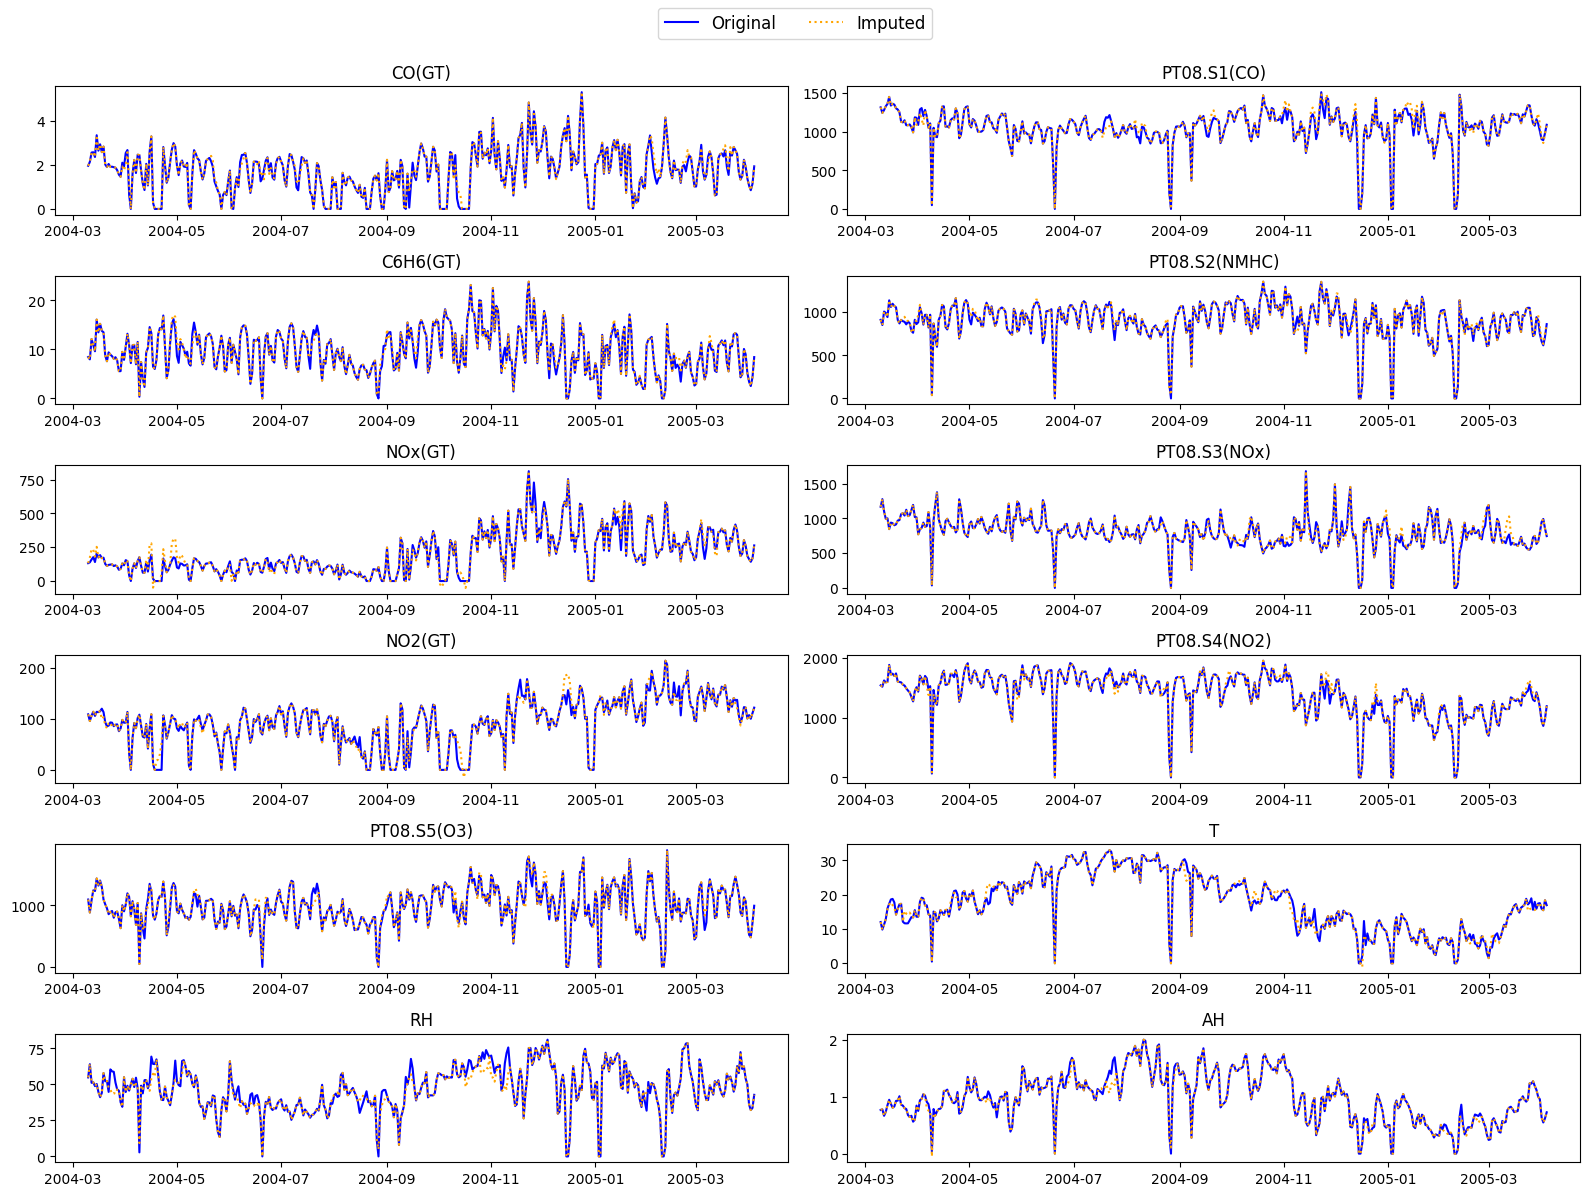

In [3]:
import missingno as msno
import pandas as pd
import numpy as np
from pypots.imputation import SAITS
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------
# 📌 CONFIGURACIÓN DE PARÁMETROS
# ----------------------------------------
seq_len = 7  # Longitud de la ventana temporal (por ejemplo, 7 días)
n_features = len(df_missing.columns)  # Número de variables (columnas)

# ----------------------------------------
# 📌 PREPARAR LOS DATOS PARA SAITS
# ----------------------------------------
# Convertir DataFrame a array numpy
data = df_missing.to_numpy(dtype=np.float32)

# Generar ventanas deslizantes de longitud seq_len
n_samples = len(data) - seq_len + 1
X = np.array([data[i:i + seq_len] for i in range(n_samples)])
print("Shape de X:", X.shape)

# ----------------------------------------
# 📌 AJUSTAR X PARA QUE COINCIDA CON EL NÚMERO DE DÍAS ORIGINALES
# ----------------------------------------
# Repetir y rellenar filas para cubrir todos los días
repeat_factor = data.shape[0] // X.shape[0]
extra_rows = data.shape[0] % X.shape[0]

expanded_arr = np.repeat(X, repeat_factor, axis=0)
expanded_arr = np.vstack([expanded_arr, X[:extra_rows]])

# Asegurar que las últimas filas coincidan con los datos originales
expanded_arr[-extra_rows:, 0, :] = data[-extra_rows:]
print("Shape de X expandido:", expanded_arr.shape)

# ----------------------------------------
# 📌 NORMALIZAR LOS DATOS
# ----------------------------------------
scaler = MinMaxScaler()
X_reshaped = expanded_arr.reshape(-1, expanded_arr.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(expanded_arr.shape)
print("Shape de X escalado:", X_scaled.shape)

# ----------------------------------------
# 📌 ENTRENAR EL MODELO SAITS
# ----------------------------------------
saits = SAITS(n_steps=seq_len, n_features=n_features,
              n_layers=2, d_model=256, d_ffn=128,
              n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=100)

dataset = {"X": X_scaled}
saits.fit(dataset)  # Entrenar el modelo
imputation = saits.impute(dataset)  # Imputar los valores faltantes

# ----------------------------------------
# 📌 DESNORMALIZAR LA IMPUTACIÓN
# ----------------------------------------
imputation_reshaped = imputation.reshape(-1, imputation.shape[-1])
imputation_denorm = scaler.inverse_transform(imputation_reshaped)
imputation_denorm = imputation_denorm.reshape(imputation.shape)

# Tomar las primeras posiciones imputadas de cada ventana
imputed_values = imputation_denorm[:, 0, :]
print("Shape de los datos imputados finales:", imputed_values.shape)

# Reconstruir el DataFrame con los valores imputados
data_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df_original.index[:imputed_values.shape[0]])

# ----------------------------------------
# 📌 VISUALIZAR ORIGINAL VS IMPUTADO
# ----------------------------------------
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    int(np.ceil(len(df_original.columns) / 2)), 2, figsize=(16, 2 * int(np.ceil(len(df_original.columns) / 2)))
)

for ax, col in zip(axes.flat, df_original.columns):
    ax.plot(df_original.index, df_original[col], label="Original", color='blue')
    ax.plot(df_original.index, data_imputed[col], ':', label="Imputed", color='orange')
    ax.set_title(col)

fig.legend(['Original', 'Imputed'], loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Ahora realizaremos el mismo ejercicio con los datos faltantes simulados en **Aleatorio**.

2025-11-16 20:35:45 [INFO]: No given device, using default device: cpu
2025-11-16 20:35:45 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-16 20:35:45 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,335,716


Shape de X: (385, 7, 12)
Shape de X expandido: (391, 7, 12)
Shape de X escalado: (391, 7, 12)


2025-11-16 20:35:46 [INFO]: Epoch 001 - training loss (MSE): 0.3228
2025-11-16 20:35:47 [INFO]: Epoch 002 - training loss (MSE): 0.1463
2025-11-16 20:35:47 [INFO]: Epoch 003 - training loss (MSE): 0.1111
2025-11-16 20:35:48 [INFO]: Epoch 004 - training loss (MSE): 0.0960
2025-11-16 20:35:48 [INFO]: Epoch 005 - training loss (MSE): 0.0819
2025-11-16 20:35:49 [INFO]: Epoch 006 - training loss (MSE): 0.0739
2025-11-16 20:35:50 [INFO]: Epoch 007 - training loss (MSE): 0.0631
2025-11-16 20:35:50 [INFO]: Epoch 008 - training loss (MSE): 0.0591
2025-11-16 20:35:51 [INFO]: Epoch 009 - training loss (MSE): 0.0534
2025-11-16 20:35:51 [INFO]: Epoch 010 - training loss (MSE): 0.0500
2025-11-16 20:35:52 [INFO]: Epoch 011 - training loss (MSE): 0.0446
2025-11-16 20:35:52 [INFO]: Epoch 012 - training loss (MSE): 0.0417
2025-11-16 20:35:53 [INFO]: Epoch 013 - training loss (MSE): 0.0392
2025-11-16 20:35:54 [INFO]: Epoch 014 - training loss (MSE): 0.0378
2025-11-16 20:35:54 [INFO]: Epoch 015 - training

Shape de los datos imputados finales: (391, 12)


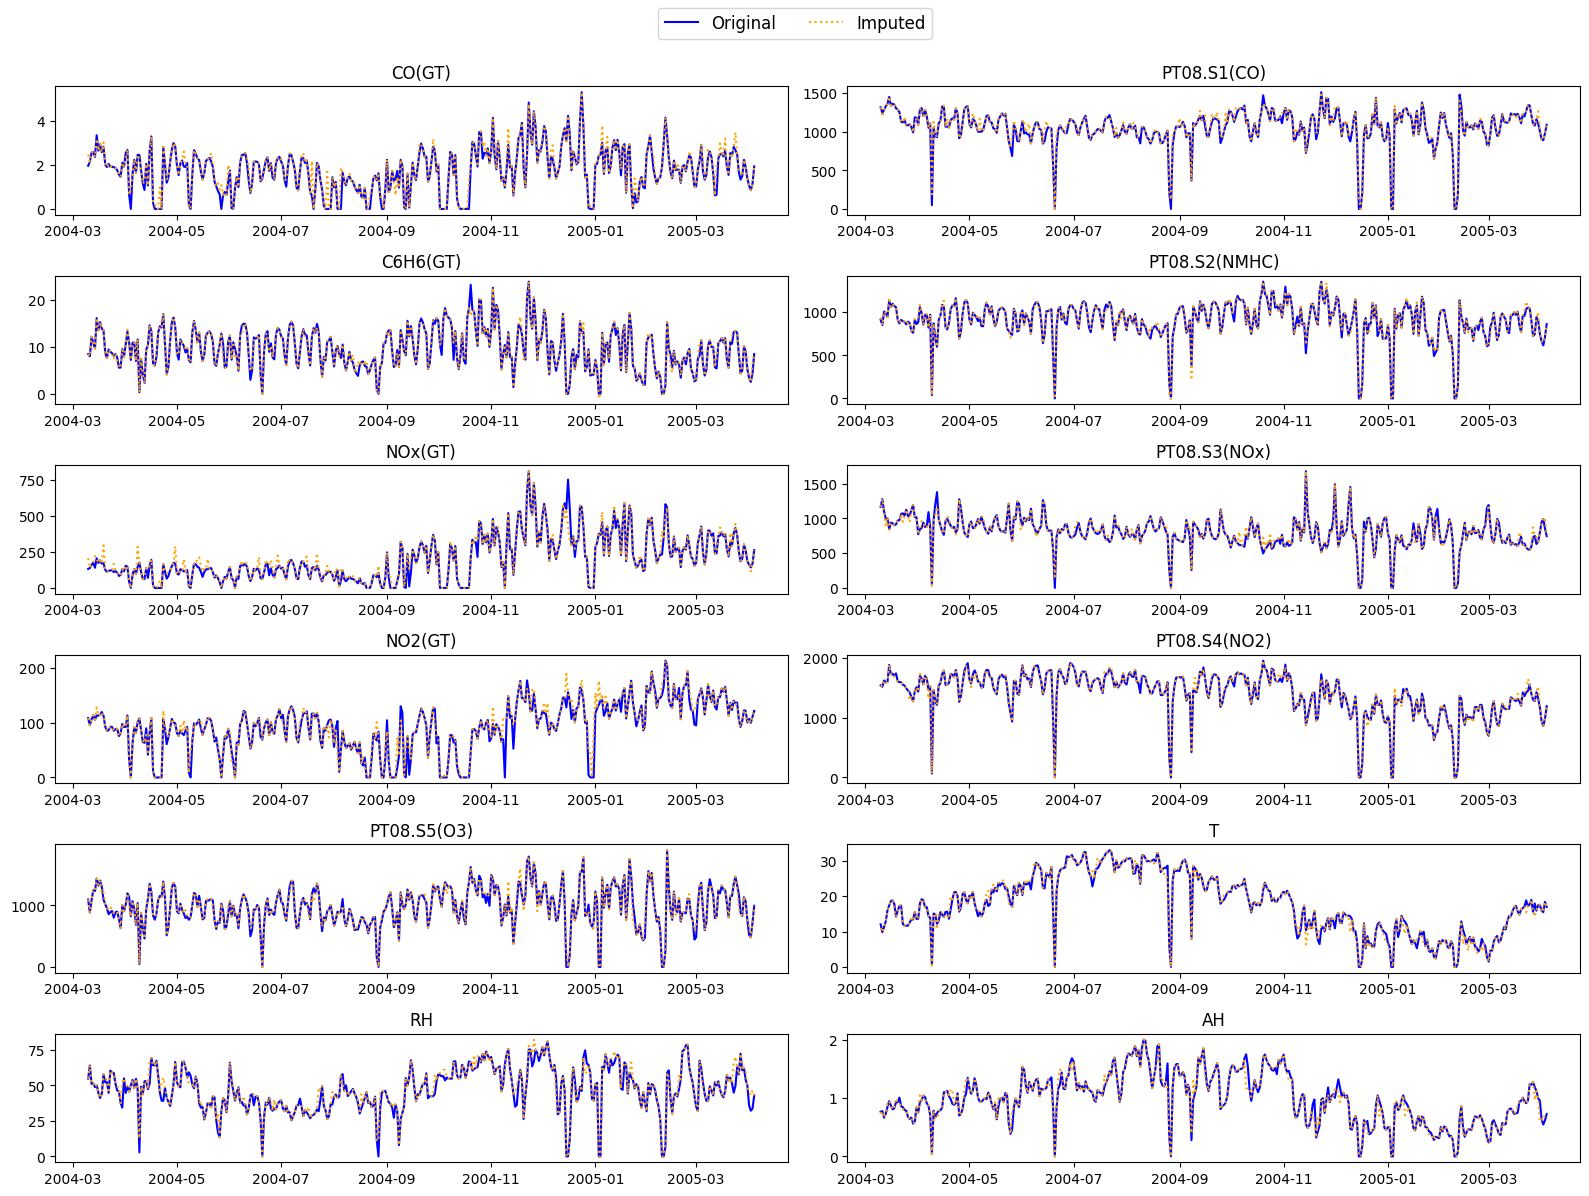

In [4]:
import missingno as msno
import pandas as pd
import numpy as np
from pypots.imputation import SAITS
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------
# 📌 CONFIGURACIÓN DE PARÁMETROS
# ----------------------------------------
seq_len = 7  # Longitud de la ventana temporal (por ejemplo, 7 días)
n_features = len(df_missing_random.columns)  # Número de variables (columnas)

# ----------------------------------------
# 📌 PREPARAR LOS DATOS PARA SAITS
# ----------------------------------------
# Convertir DataFrame a array numpy
data = df_missing_random.to_numpy(dtype=np.float32)

# Generar ventanas deslizantes de longitud seq_len
n_samples = len(data) - seq_len + 1
X = np.array([data[i:i + seq_len] for i in range(n_samples)])
print("Shape de X:", X.shape)

# ----------------------------------------
# 📌 AJUSTAR X PARA QUE COINCIDA CON EL NÚMERO DE DÍAS ORIGINALES
# ----------------------------------------
# Repetir y rellenar filas para cubrir todos los días
repeat_factor = data.shape[0] // X.shape[0]
extra_rows = data.shape[0] % X.shape[0]

expanded_arr = np.repeat(X, repeat_factor, axis=0)
expanded_arr = np.vstack([expanded_arr, X[:extra_rows]])

# Asegurar que las últimas filas coincidan con los datos originales
expanded_arr[-extra_rows:, 0, :] = data[-extra_rows:]
print("Shape de X expandido:", expanded_arr.shape)

# ----------------------------------------
# 📌 NORMALIZAR LOS DATOS
# ----------------------------------------
scaler = MinMaxScaler()
X_reshaped = expanded_arr.reshape(-1, expanded_arr.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(expanded_arr.shape)
print("Shape de X escalado:", X_scaled.shape)

# ----------------------------------------
# 📌 ENTRENAR EL MODELO SAITS
# ----------------------------------------
saits = SAITS(n_steps=seq_len, n_features=n_features,
              n_layers=2, d_model=256, d_ffn=128,
              n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=100)

dataset = {"X": X_scaled}
saits.fit(dataset)  # Entrenar el modelo
imputation = saits.impute(dataset)  # Imputar los valores faltantes

# ----------------------------------------
# 📌 DESNORMALIZAR LA IMPUTACIÓN
# ----------------------------------------
imputation_reshaped = imputation.reshape(-1, imputation.shape[-1])
imputation_denorm = scaler.inverse_transform(imputation_reshaped)
imputation_denorm = imputation_denorm.reshape(imputation.shape)

# Tomar las primeras posiciones imputadas de cada ventana
imputed_values = imputation_denorm[:, 0, :]
print("Shape de los datos imputados finales:", imputed_values.shape)

# Reconstruir el DataFrame con los valores imputados
data_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df_original.index[:imputed_values.shape[0]])

# ----------------------------------------
# 📌 VISUALIZAR ORIGINAL VS IMPUTADO
# ----------------------------------------
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    int(np.ceil(len(df_original.columns) / 2)), 2, figsize=(16, 2 * int(np.ceil(len(df_original.columns) / 2)))
)

for ax, col in zip(axes.flat, df_original.columns):
    ax.plot(df_original.index, df_original[col], label="Original", color='blue')
    ax.plot(df_original.index, data_imputed[col], ':', label="Imputed", color='orange')
    ax.set_title(col)

fig.legend(['Original', 'Imputed'], loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 📊 Resultados de la imputación con SAITS

| Variable        | MAE    | MSE       | RMSE   | R²      |
|-----------------|--------|-----------|--------|---------|
| CO(GT)          | 0.281  | 0.106     | 0.326  | 0.746   |
| PT08.S1(CO)     | 61.061 | 5673.883  | 75.325 | 0.850   |
| C6H6(GT)        | 0.995  | 1.878     | 1.370  | 0.872   |
| PT08.S2(NMHC)   | 37.641 | 2561.053  | 50.607 | 0.929   |
| NOx(GT)         | 48.429 | 3705.005  | 60.869 | 0.866   |
| PT08.S3(NOx)    | 70.764 | 9218.081  | 96.011 | 0.780   |
| NO2(GT)         | 15.125 | 357.961   | 18.920 | 0.861   |
| PT08.S4(NO2)    | 78.496 | 10095.427 | 100.476| 0.858   |
| PT08.S5(O3)     | 94.586 | 13372.547 | 115.640| 0.864   |
| T               | 2.115  | 6.943     | 2.635  | 0.840   |
| RH              | 6.708  | 65.337    | 8.083  | 0.674   |
| AH              | 0.125  | 0.022     | 0.147  | 0.859   |


### 💡 Preguntas  
- ¿Qué variables presentan la imputación más precisa según R²? ¿Por qué creen que ocurre?
*Según R2 las variables con mejor imputación sería PT08.S2 y C6H6, lo cual se debe a que son las variables con un compartamiento constante a lo largo del tiempo.*
- ¿Qué características del dataset podrían dificultar la imputación de ciertas variables?
*Comportamientos muy variados a lo largo del tiempo para ciertas variables podrían difucultar el encontrar un mecanismo de imputación adecuado.*
- ¿El error de imputación sería aceptable para un análisis ambiental? ¿Por qué?
*Debido a que el análisis se realiza con los datos correspondientes a una semana determinamos que el error de imputación es aceptable, pues al realizar una simulación de valores nulos, nos damos cuenta que el modelo SAITS trabaja muy bien para imputar valores y cuando se tratan de análisis ambientales se tiene una gran cantidad de variables y muchos resultados de sensores por revisar, por lo que utilizar estos modelos ayuda a los profesionales en temas ambientales a realizar análisis más precisos y eficientes.*


## 🎯 Modelado de CO(GT) usando Transformer

Una vez imputados los valores faltantes, el objetivo es **modelar la serie temporal de CO(GT)** para predecir su valor futuro a partir de sus valores anteriores y/o las demás variables.

👉 **Variable objetivo**: CO(GT)  
👉 **Justificación**: Es una variable ambiental clave, con tendencia y estacionalidad diarias evidentes, lo que la hace adecuada para modelado secuencial.

### 📌 Descripción del flujo
El modelo Transformer recibe secuencias pasadas y aprende a predecir el siguiente valor de CO(GT).

### 📌 Código base

c:\Users\arbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 1.3349
Epoch 2/50, Loss: 0.7045
Epoch 3/50, Loss: 0.6146
Epoch 4/50, Loss: 0.6389
Epoch 5/50, Loss: 0.6636
Epoch 6/50, Loss: 0.6200
Epoch 7/50, Loss: 0.6728
Epoch 8/50, Loss: 0.6325
Epoch 9/50, Loss: 0.6181
Epoch 10/50, Loss: 0.5998
Epoch 11/50, Loss: 0.6231
Epoch 12/50, Loss: 0.5936
Epoch 13/50, Loss: 0.5948
Epoch 14/50, Loss: 0.5932
Epoch 15/50, Loss: 0.6469
Epoch 16/50, Loss: 0.6244
Epoch 17/50, Loss: 0.5955
Epoch 18/50, Loss: 0.6451
Epoch 19/50, Loss: 0.6021
Epoch 20/50, Loss: 0.6233
Epoch 21/50, Loss: 0.6325
Epoch 22/50, Loss: 0.6100
Epoch 23/50, Loss: 0.6231
Epoch 24/50, Loss: 0.6199
Epoch 25/50, Loss: 0.5875
Epoch 26/50, Loss: 0.5974
Epoch 27/50, Loss: 0.5934
Epoch 28/50, Loss: 0.5900
Epoch 29/50, Loss: 0.5908
Epoch 30/50, Loss: 0.5887
Epoch 31/50, Loss: 0.5968
Epoch 32/50, Loss: 0.6063
Epoch 33/50, Loss: 0.5718
Epoch 34/50, Loss: 0.5989
Epoch 35/50, Loss: 0.5847
Epoch 36/50, Loss: 0.5934
Epoch 37/50, Loss: 0.5502
Epoch 38/50, Loss: 0.5817
Epoch 39/50, Loss: 0.

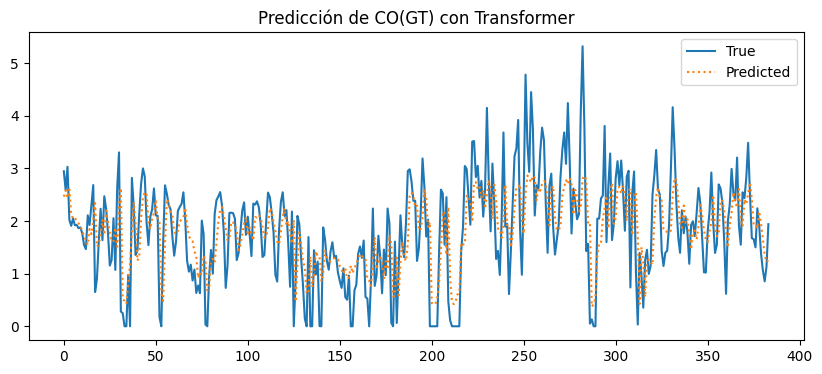

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------------------
# 📌 PREPARAR LOS DATOS
# ----------------------------------------
seq_len = 7  # Usaremos 7 días como ventana (se puede ajustar)

# Tomamos la serie imputada
series = data_imputed['CO(GT)'].to_numpy(dtype=np.float32)

# Generar secuencias y etiquetas
X = []
y = []
for i in range(len(series) - seq_len):
    X.append(series[i:i + seq_len])
    y.append(series[i + seq_len])

X = np.array(X)  # (n_samples, seq_len)
y = np.array(y)  # (n_samples,)

# Añadir dimensión de características (1 característica: CO)
X = X[..., np.newaxis]  # (n_samples, seq_len, 1)

# Crear dataloader
batch_size = 16
dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ----------------------------------------
# 📌 DEFINIR EL TRANSFORMER
# ----------------------------------------
class SimpleTransformer(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_len, 1)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)  # Transformer espera (seq_len, batch, d_model)
        x = self.transformer(x)
        x = x[-1]  # Tomamos la salida del último paso temporal
        x = self.output(x).squeeze(1)  # (batch,)
        return x

# Instanciar el modelo
model = SimpleTransformer(seq_len=seq_len)

# ----------------------------------------
# 📌 ENTRENAR
# ----------------------------------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss / len(loader):.4f}")

# ----------------------------------------
# 📌 EVALUAR (p. ej. en todo el conjunto)
# ----------------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(X)).numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(y, label='True')
plt.plot(y_pred, label='Predicted', linestyle=':')
plt.legend()
plt.title("Predicción de CO(GT) con Transformer")
plt.show()

### ✅ Lo que debes hacer

* Ejecutar el código.
* Observar las predicciones generadas.
* Reflexionar: ¿Cómo se ajusta el modelo a los datos? ¿Qué podríamos mejorar (más capas, regularización, más features)?


---


   *Como podemos observar el modelo se ajusta de buena manera aunque no tan precisa como quisieramos. Podríamos deducir que si colocamos más capas el modelo podría mejorar su precisión.*


---


## 🎯 Forecasting multivariado de CO con Transformer

El objetivo es modelar y predecir el CO utilizando un Transformer multivariado.  
👉 El modelo aprende a partir de los datos previos y se evalúa su desempeño sobre un conjunto de test (último 20% del tiempo).

Se graficará la serie completa mostrando el ajuste y se compararán los valores reales y predichos en test.


### 📌 Código base

Epoch 1/50, Loss: 1.5755
Epoch 2/50, Loss: 1.0443
Epoch 3/50, Loss: 0.9429
Epoch 4/50, Loss: 0.8379
Epoch 5/50, Loss: 0.7958
Epoch 6/50, Loss: 0.8632
Epoch 7/50, Loss: 0.7978
Epoch 8/50, Loss: 0.7468
Epoch 9/50, Loss: 0.7130
Epoch 10/50, Loss: 1.0368
Epoch 11/50, Loss: 0.7877
Epoch 12/50, Loss: 0.6863
Epoch 13/50, Loss: 0.7307
Epoch 14/50, Loss: 0.7306
Epoch 15/50, Loss: 0.7656
Epoch 16/50, Loss: 0.6790
Epoch 17/50, Loss: 0.6333
Epoch 18/50, Loss: 0.7170
Epoch 19/50, Loss: 0.7447
Epoch 20/50, Loss: 0.6431
Epoch 21/50, Loss: 0.6944
Epoch 22/50, Loss: 0.6674
Epoch 23/50, Loss: 0.6062
Epoch 24/50, Loss: 0.6218
Epoch 25/50, Loss: 0.5887
Epoch 26/50, Loss: 0.6164
Epoch 27/50, Loss: 0.6659
Epoch 28/50, Loss: 0.6506
Epoch 29/50, Loss: 0.6886
Epoch 30/50, Loss: 0.5625
Epoch 31/50, Loss: 0.6056
Epoch 32/50, Loss: 0.5537
Epoch 33/50, Loss: 0.5809
Epoch 34/50, Loss: 0.5951
Epoch 35/50, Loss: 0.5848
Epoch 36/50, Loss: 0.6903
Epoch 37/50, Loss: 0.5890
Epoch 38/50, Loss: 0.5693
Epoch 39/50, Loss: 0.

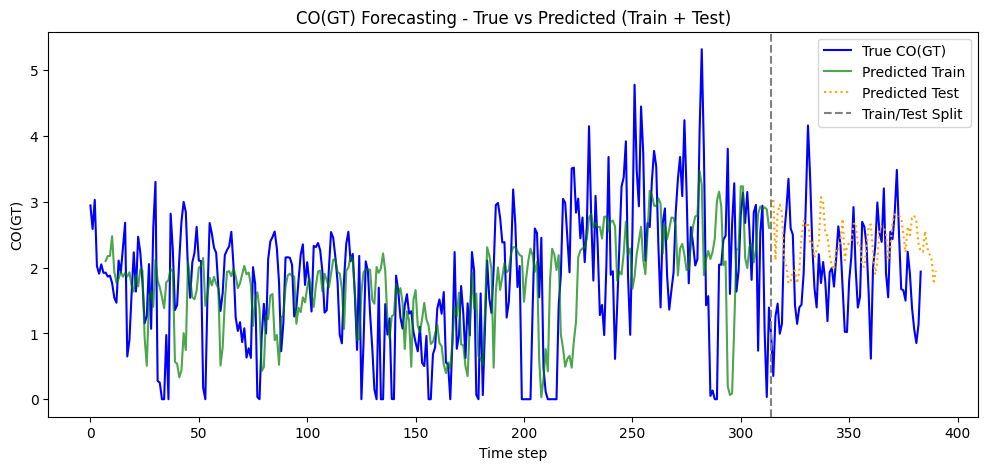

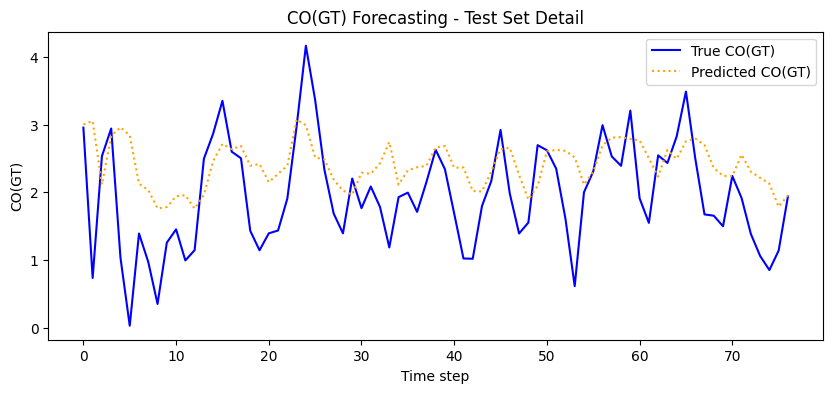

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# 📌 PREPARAR LOS DATOS
# ----------------------------------------
seq_len = 7
data_arr = data_imputed.to_numpy(dtype=np.float32)

# Secuencias y etiquetas
X = []
y = []
for i in range(len(data_arr) - seq_len):
    X.append(data_arr[i:i + seq_len])
    y.append(data_arr[i + seq_len][data_imputed.columns.get_loc('CO(GT)')])

X = np.array(X)
y = np.array(y)

# Separar train / test (80% / 20%)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# DataLoader
batch_size = 16
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
                          batch_size=batch_size, shuffle=True)

# ----------------------------------------
# 📌 DEFINIR EL TRANSFORMER
# ----------------------------------------
class ForecastTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        x = x[-1]
        x = self.output(x).squeeze(1)
        return x

model = ForecastTransformer(n_features=X.shape[2])

# ----------------------------------------
# 📌 ENTRENAR
# ----------------------------------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# ----------------------------------------
# 📌 PREDICCIONES
# ----------------------------------------
model.eval()
with torch.no_grad():
    y_pred_train = model(torch.from_numpy(X_train)).numpy()
    y_pred_test = model(torch.from_numpy(X_test)).numpy()

# ----------------------------------------
# 📌 PLOT DE LA SERIE COMPLETA
# ----------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(range(len(y)), y, label='True CO(GT)', color='blue')
plt.plot(range(seq_len, seq_len + len(y_pred_train)), y_pred_train, label='Predicted Train', color='green', alpha=0.7)
plt.plot(range(seq_len + len(y_pred_train), seq_len + len(y_pred_train) + len(y_pred_test)),
         y_pred_test, label='Predicted Test', color='orange', linestyle=':')
plt.axvline(seq_len + len(y_pred_train), color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("CO(GT) Forecasting - True vs Predicted (Train + Test)")
plt.xlabel("Time step")
plt.ylabel("CO(GT)")
plt.show()

# ----------------------------------------
# 📌 PLOT COMPARATIVO TEST FINAL
# ----------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='True CO(GT)', color='blue')
plt.plot(y_pred_test, label='Predicted CO(GT)', color='orange', linestyle=':')
plt.legend()
plt.title("CO(GT) Forecasting - Test Set Detail")
plt.xlabel("Time step")
plt.ylabel("CO(GT)")
plt.show()

### ✅ Lo que se espera

* Analizar el gráfico de la serie completa: ¿cómo se ajusta el modelo en train y en test?


---

*La precisión del modelo no es la más adecuada en train lo cual se evidencia al momento de predecir los valores en test. Con lo cual no tenemos un modelo muy preciso.*

---

* Observar el detalle en test: ¿qué tan bien predice el modelo los valores futuros?

---

*La precisión no es muy buena, aunque la línea de tendencia es similar a los línea de valores reales, podemos inferir que para los valores más pequeños de CO se le dificulta más al modelo predecir.*

---

* Proponer mejoras si fuera necesario (más capas, regularización, ajuste de hiperparámetros).

---
*Para el caso de la **imputación**, para las variables con R2 más pequeño se podría realizar una imputación combinada.*

*Para el caso del **Transformer** sugerimos probar ajustes de hiperparámetros: más capas, más cabezas de atención. También podrían explorar arquitecturas alternativas como LSTM o TCN.*

---